In [50]:
# Import required libraries
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import plotly.express as px


In [2]:
# Load the RNA-seq data
rnaseq_df = pd.read_csv('/Users/johnsmith/Desktop/Senior Design Stuff/tcga.brca.rnaseq.unstranded.raw.counts.matrix-2.txt', sep='\t', index_col=0)

# Load the HRD score data
hrd_df = pd.read_excel('/Users/johnsmith/Desktop/Senior Design Stuff/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('/Users/johnsmith/Desktop/Senior Design Stuff/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')


In [3]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
hrd_samples = set(hrd_df['sample'])
brca_samples = set(brca_df.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(hrd_samples).intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))
#common_samples


Number of common samples: 864


In [4]:
# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
hrd_df_common = hrd_df[hrd_df['sample'].isin(common_samples)]
brca_df_common = brca_df[brca_df.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("hrd_df_common:", hrd_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

rnaseq_df_common: (929, 60663)
hrd_df_common: (864, 5)
brca_df_common: (864, 33)


In [5]:
#rnaseq_df_common.head()

In [6]:
#merge metadata

metadata = pd.merge(hrd_df_common, brca_df_common, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
metadata.head()

(864, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


HRD  Telomeric AI  LST  HRD-sum BRCA1_somatic_null  \
sample                                                             
TCGA-A1-A0SB    0             0    0        0                  0   
TCGA-A1-A0SD   10            10    7       27                  0   
TCGA-A1-A0SE    6             6    1       13                  0   
TCGA-A1-A0SF    7            11    8       26                  0   
TCGA-A1-A0SG    3             2    4        9                  0   

             BRCA1_germ_bi_allelic BRCA1_germ_mono_allelic BRCA1_deletion  \
sample                                                                      
TCGA-A1-A0SB                     0                       0              0   
TCGA-A1-A0SD                     0                       0              0   
TCGA-A1-A0SE                     0                       0              0   
TCGA-A1-A0SF                     0                       0              0   
TCGA-A1-A0SG                     0                       0              0   

             BRCA1_epigenetic_silencing BRCA1_mRNA  ...   H2.norm   H3.norm  \
sample                                              ...                       
TCGA-A1-A0SB                          0          0  ...  0.044837  0.635070   
TCGA-A1-A0SD                          0          0  ...  0.254169  0.703974   
TCGA-A1-A0SE                          0          0  ...  0.102998  0.740053   
TCGA-A1-A0SF                          0          0  ...  0.000000  0.395329   
TCGA-A1-A0SG                          0          0  ...  0.183277  0.776319   

               H4.norm event.BRCA1 event.BRCA2 event.RAD51C event.PALB2  \
sample                                                                    
TCGA-A1-A0SB  0.000000           0           0            0           0   
TCGA-A1-A0SD  0.041857           0           0            0           0   
TCGA-A1-A0SE  0.120368           0           0            0           0   
TCGA-A1-A0SF  0.604671           0           0            0           0   
TCGA-A1-A0SG  0.040404           0           0            0           0   

             event.All Events event.PAM50 event.TNBC  
sample                                                
TCGA-A1-A0SB                0         NaN          0  
TCGA-A1-A0SD                0        LumA          0  
TCGA-A1-A0SE                0        LumA          0  
TCGA-A1-A0SF                0        LumA          0  
TCGA-A1-A0SG                0        LumA          0  

[5 rows x 37 columns]

In [7]:

# Start with the original dataframe
metadata_filtered = metadata.copy()

# Drop rows where event.BRCA1 is '1'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
metadata_filtered = metadata_filtered[metadata_filtered['event.PALB2'] != '2']

print (metadata_filtered.shape)
print(metadata_filtered.columns)
metadata_filtered.head()

metadata = metadata_filtered
metadata['HRD_status'] = ['HRD' if x >= 42 else 'HR' for x in metadata['HRD-sum']]
#metadata[metadata['event.BRCA1'] == '1']

(857, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


In [8]:
# drop rna samples not in metadata
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samp = set(rnaseq_df['Case ID'])
metadata_samp = set(metadata.index)

# Find the intersection of all sample IDs
common_samp = rnaseq_samp.intersection(metadata_samp)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samp))



Number of common samples: 857


In [9]:
# Drop samples that are not common between metadata and rnaseq data
rnaseq_df_filtered = rnaseq_df_common[rnaseq_df_common['Case ID'].isin(common_samp)]
rnaseq_df_filtered.shape
#print(metadata.shape)

(921, 60663)

In [10]:
#rnaseq_df_filtered.head()


In [11]:

rnaseq_df_filtered = rnaseq_df_filtered.set_index('Case ID').drop(['Sample ID', 'Sample Type'], axis=1)


In [12]:
rnaseq_df_filtered = rnaseq_df_filtered.round().astype(int)
rnaseq_df_filtered = rnaseq_df_filtered[~rnaseq_df_filtered.index.duplicated(keep='first')]

In [13]:
print(f"Shape of rnaseq_df_filtered: {rnaseq_df_filtered.shape}")
print(f"Shape of metadata: {metadata.shape}")

Shape of rnaseq_df_filtered: (857, 60660)
Shape of metadata: (857, 38)


In [14]:
print("rnaseq_df_filtered index:")
print(rnaseq_df_filtered.index[:5])  # Print first 5 index values
print("\nmetadata index:")
print(metadata.index[:5])  # Print first 5 index values

# Check for any mismatches
mismatched = set(rnaseq_df_filtered.index) ^ set(metadata.index)
print(f"\nNumber of mismatched indices: {len(mismatched)}")
if len(mismatched) > 0:
    print("Sample of mismatched indices:")
    print(list(mismatched)[:5])  # Print up to 5 mismatched indices


rnaseq_df_filtered index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object', name='Case ID')

metadata index:
Index(['TCGA-A1-A0SB', 'TCGA-A1-A0SD', 'TCGA-A1-A0SE', 'TCGA-A1-A0SF',
       'TCGA-A1-A0SG'],
      dtype='object', name='sample')

Number of mismatched indices: 0


In [15]:
#filtering metadata for nan Pam50 subtypes
metadata_dropna = metadata[~metadata['event.PAM50'].isna()]
metadata_dropna['event.PAM50'].unique()

array(['LumA', 'LumB', 'Basal', 'Her2'], dtype=object)

In [16]:
# Find common indices
common_indices = rnaseq_df_filtered.index.intersection(metadata_dropna.index)

# Filter both DataFrames to keep only common indices
rnaseq_df_filtered = rnaseq_df_filtered.loc[common_indices]
metadata_dropna = metadata_dropna.loc[common_indices]

# Verify the shapes and indices again
print(f"Shape of rnaseq_df_filtered after alignment: {rnaseq_df_filtered.shape}")
print(f"Shape of metadata after alignment: {metadata_dropna.shape}")

print("\nrnaseq_df_filtered index:")
print(rnaseq_df_filtered.index[:5])
print("\nmetadata index:")
print(metadata_dropna.index[:5])

Shape of rnaseq_df_filtered after alignment: (843, 60660)
Shape of metadata after alignment: (843, 38)

rnaseq_df_filtered index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object')

metadata index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object')


In [17]:
#metadata_dropna[['HRD_status','event.PAM50']]
#rnaseq_df_filtered

In [24]:

# Step 2: Create the DESeqDataSet object
dds = DeseqDataSet(
    counts=rnaseq_df_filtered,
    metadata=metadata_dropna,
    design_factors=["HRD_status"],
)


/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_46168/2970829575.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(


In [25]:

# Step 3: Run the differential expression analysis
dds.deseq2()


Fitting size factors...
... done in 1.70 seconds.

Fitting dispersions...
... done in 19.61 seconds.

Fitting dispersion trend curve...
... done in 0.89 seconds.

Fitting MAP dispersions...
... done in 22.80 seconds.

Fitting LFCs...
... done in 13.82 seconds.

Calculating cook's distance...
... done in 7.73 seconds.

Replacing 7635 outlier genes.

Fitting dispersions...
... done in 3.35 seconds.

Fitting MAP dispersions...
... done in 2.99 seconds.

Fitting LFCs...
... done in 2.49 seconds.



In [28]:

# Step 4: Get the results
# stat_res = DeseqStats(dds)
# stat_res.summary()

# Get results table
#results = stat_res.results_df
stats = DeseqStats(dds, contrast=["HRD-status", "HRD", "HR"])
stats.summary()
results = stats.results_df
# Display the top differentially expressed genes
#print(results.sort_values('padj').head(10))

results


Running Wald tests...
... done in 2.74 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TSPAN6      3205.150166        0.113436  0.079847  1.420668  1.554134e-01   
TNMD          50.856466       -0.690929  0.192206 -3.594735  3.247225e-04   
DPM1        2506.846125        0.390477  0.047074  8.294998  1.085872e-16   
SCYL3       1669.317419       -0.288433  0.045554 -6.331630  2.425844e-10   
C1orf112     761.472956        0.552774  0.060263  9.172727  4.612028e-20   
...                 ...             ...       ...       ...           ...   
AC008763.4     0.139249        0.117514  0.564605  0.208135  8.351238e-01   
AL592295.6   448.806437       -0.044777  0.056731 -0.789286  4.299451e-01   
AC006486.3     0.000000             NaN       NaN       NaN           NaN   
AL391628.1     8.110358       -0.043118  0.081161 -0.531260  5.952389e-01   
AP006621.6    34.086150       -0.271339  0.089822 -3.020861  2.520568e-03   

                

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TSPAN6      3205.150166        0.113436  0.079847  1.420668  1.554134e-01   
TNMD          50.856466       -0.690929  0.192206 -3.594735  3.247225e-04   
DPM1        2506.846125        0.390477  0.047074  8.294998  1.085872e-16   
SCYL3       1669.317419       -0.288433  0.045554 -6.331630  2.425844e-10   
C1orf112     761.472956        0.552774  0.060263  9.172727  4.612028e-20   
...                 ...             ...       ...       ...           ...   
AC008763.4     0.139249        0.117514  0.564605  0.208135  8.351238e-01   
AL592295.6   448.806437       -0.044777  0.056731 -0.789286  4.299451e-01   
AC006486.3     0.000000             NaN       NaN       NaN           NaN   
AL391628.1     8.110358       -0.043118  0.081161 -0.531260  5.952389e-01   
AP006621.6    34.086150       -0.271339  0.089822 -3.020861  2.520568e-03   

                    padj  
TSPAN6      2.272388e-01  
TNMD        8.838586e-04  
DPM1        1.357887e-15  
SCYL3       1.510050e-09  
C1orf112    8.172645e-19  
...                  ...  
AC008763.4           NaN  
AL592295.6  5.293022e-01  
AC006486.3           NaN  
AL391628.1  6.828997e-01  
AP006621.6  5.792679e-03  

[60660 rows x 6 columns]

In [39]:
pam50_dict = {}
for pam50_subtype in metadata_dropna['event.PAM50'].unique():
    # Filter metadata for HRD and HR within each PAM50 subtype
    hrd_metadata = metadata_dropna[(metadata_dropna['HRD_status'] == 'HRD') & (metadata_dropna['event.PAM50'] == pam50_subtype)]
    hr_metadata = metadata_dropna[(metadata_dropna['HRD_status'] == 'HR') & (metadata_dropna['event.PAM50'] == pam50_subtype)]

    # Concatenate HRD and HR data for the subtype
    combined_metadata = pd.concat([hrd_metadata, hr_metadata])

    # print(combined_metadata)
    # break
    # Filter count data for samples in combined metadata
    #combined_counts = rnaseq_df_filtered[combined_metadata.index]


    # Find common indices
    common_indices = rnaseq_df_filtered.index.intersection(combined_metadata.index)

    # print(common_indices)
    # break
    # Filter both DataFrames to keep only common indices
    combined_counts = rnaseq_df_filtered.loc[common_indices]
    combined_metadata_common = combined_metadata.loc[common_indices]

    # print(combined_metadata_common['HRD_status'])
    
    # break

    # Create DESeq2 dataset
    dds = DeseqDataSet(counts=combined_counts, 
                       metadata=combined_metadata_common, 
                       design_factors=["HRD_status"], 
                      )

    # Run DESeq2
    dds.deseq2()

    # print("Design matrix columns:", dds.obsm['design_matrix'].columns)
    # break

    # Get results for HRD vs HR comparison within this subtype
    results = DeseqStats(dds, contrast=["HRD-status", "HRD", "HR"])
    results.summary()
    results_df = results.results_df

    # Filter for significantly differentially expressed genes (p-adj < 0.05)
    pam50_dict[pam50_subtype] = results_df[results_df['pvalue'] < 0.05]
    #common_genes[pam50_subtype] = set(significant_genes)

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_46168/851801500.py:30: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=combined_counts,
Fitting size factors...
... done in 0.10 seconds.

Fitting dispersions...
... done in 8.30 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 9.48 seconds.

Fitting LFCs...
... done in 6.25 seconds.

Calculating cook's distance...
... done in 0.29 seconds.

Replacing 5022 outlier genes.

Fitting dispersions...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 0.87 seconds.

Fitting LFCs...
... done in 0.65 seconds.

Running Wald tests...
... done in 2.11 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      3126.284146        0.121993  0.231881  0.526102  0.598817   
TNMD          15.801154       -0.133851  0.559972 -0.239032  0.811081   
DPM1        2884.821185        0.073083  0.163656  0.446567  0.655188   
SCYL3       1642.064358       -0.180789  0.171060 -1.056874  0.290569   
C1orf112     698.961023        0.232868  0.181696  1.281633  0.199971   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.055004       -0.007614  2.673335 -0.002848  0.997727   
AL592295.6   400.618018       -0.197163  0.230876 -0.853978  0.393117   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     6.245845        0.205582  0.271663  0.756754  0.449197   
AP006621.6    63.675952       -1.237753  0.370542 -3.340382  0.000837   

                padj  
TSPAN6      0.888739  
TNMD        0.9601

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_46168/851801500.py:30: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=combined_counts,
Fitting size factors...
... done in 0.59 seconds.

Fitting dispersions...
... done in 10.78 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 13.17 seconds.

Fitting LFCs...
... done in 7.61 seconds.

Calculating cook's distance...
... done in 1.18 seconds.

Replacing 6064 outlier genes.

Fitting dispersions...
... done in 1.29 seconds.

Fitting MAP dispersions...
... done in 1.27 seconds.

Fitting LFCs...
... done in 0.96 seconds.

Running Wald tests...
... done in 2.13 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      2441.419886       -0.113535  0.158897 -0.714520  0.474906   
TNMD          37.285179       -0.955327  0.392469 -2.434145  0.014927   
DPM1        3082.254862        0.238984  0.101162  2.362397  0.018157   
SCYL3       1751.057907       -0.191229  0.088167 -2.168945  0.030087   
C1orf112     891.084929        0.256668  0.119877  2.141090  0.032267   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.146647        0.243259  1.012640  0.240222  0.810158   
AL592295.6   536.873905       -0.271756  0.107588 -2.525885  0.011541   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     7.923991        0.011701  0.165835  0.070560  0.943748   
AP006621.6    25.906255       -0.243882  0.154611 -1.577385  0.114707   

                padj  
TSPAN6      0.749308  
TNMD        0.1237

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_46168/851801500.py:30: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=combined_counts,
Fitting size factors...
... done in 0.67 seconds.

Fitting dispersions...
... done in 14.34 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 15.84 seconds.

Fitting LFCs...
... done in 10.03 seconds.

Calculating cook's distance...
... done in 2.72 seconds.

Replacing 5105 outlier genes.

Fitting dispersions...
... done in 1.40 seconds.

Fitting MAP dispersions...
... done in 1.54 seconds.

Fitting LFCs...
... done in 0.99 seconds.

Running Wald tests...
... done in 2.56 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      3134.482009       -0.547427  0.201575 -2.715752  0.006613   
TNMD          58.669703       -0.938723  0.436366 -2.151227  0.031458   
DPM1        2053.125178        0.481499  0.099724  4.828304  0.000001   
SCYL3       1765.960425       -0.058344  0.107166 -0.544427  0.586148   
C1orf112     577.884821        0.066428  0.123506  0.537849  0.590681   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.133167       -0.071869  1.509291 -0.047617  0.962021   
AL592295.6   432.652328        0.388975  0.134980  2.881736  0.003955   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     8.569988       -0.032803  0.195565 -0.167736  0.866791   
AP006621.6    30.259944       -0.762389  0.191186 -3.987687  0.000067   

                padj  
TSPAN6      0.047581  
TNMD        0.1324

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_46168/851801500.py:30: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=combined_counts,
Fitting size factors...
... done in 0.63 seconds.

Fitting dispersions...
... done in 12.71 seconds.

Fitting dispersion trend curve...
... done in 1.10 seconds.

Fitting MAP dispersions...
... done in 22.51 seconds.

Fitting LFCs...
... done in 20.99 seconds.

Calculating cook's distance...
... done in 1.14 seconds.

Replacing 5852 outlier genes.

Fitting dispersions...
... done in 4.77 seconds.

Fitting MAP dispersions...
... done in 3.98 seconds.

Fitting LFCs...
... done in 2.56 seconds.

Running Wald tests...
... done in 4.11 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6      4328.605474       -0.076081  0.128895 -0.590256  0.555019   
TNMD          32.019940        1.100118  0.430135  2.557612  0.010539   
DPM1        2877.493819        0.008037  0.093179  0.086248  0.931269   
SCYL3       1273.178538       -0.146394  0.103343 -1.416577  0.156607   
C1orf112    1157.423733       -0.061664  0.137426 -0.448705  0.653645   
...                 ...             ...       ...       ...       ...   
AC008763.4     0.188032        0.136116  1.304933  0.104309  0.916924   
AL592295.6   407.122125       -0.053390  0.120584 -0.442759  0.657940   
AC006486.3     0.000000             NaN       NaN       NaN       NaN   
AL391628.1     7.803711        0.042903  0.190036  0.225763  0.821386   
AP006621.6    38.496432       -0.443538  0.192311 -2.306364  0.021090   

                padj  
TSPAN6      0.851343  
TNMD        0.1740

In [40]:
pam50_dict.keys()

dict_keys(['Her2', 'LumB', 'LumA', 'Basal'])

In [52]:
Her2_genes = set(pam50_dict['Her2'].index)
LumB_genes = set(pam50_dict['LumB'].index)
LumA_genes = set(pam50_dict['LumA'].index)
Basal_genes = set(pam50_dict['Basal'].index)

shared_de_genes = Her2_genes.intersection(LumA_genes).intersection(LumB_genes).intersection(Basal_genes)

In [54]:
len(shared_de_genes)

84

In [185]:
px.scatter(results, x = 'log2FoldChange', y = 'pvalue')

In [186]:
# 1. Separate upregulated and downregulated genes
upregulated = results[results['log2FoldChange'] > 0]
downregulated = results[results['log2FoldChange'] < 0]

# 2. Sort each by p-value
upregulated_sorted = upregulated.sort_values(by='padj')
downregulated_sorted = downregulated.sort_values(by='padj')

# 3. Calculate the number of genes to select (top 2%)
top_n_upregulated = int(len(upregulated_sorted) * 0.05) or 1  # Ensure at least one gene is selected
top_n_downregulated = int(len(downregulated_sorted) * 0.05) or 1

# 4. Select the top 2% based on p-value
top_upregulated = upregulated_sorted.head(top_n_upregulated)
top_downregulated = downregulated_sorted.head(top_n_downregulated)

# Combine the results
top_genes = pd.concat([top_upregulated, top_downregulated])
top_genes


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
NCAN           69.839798        5.748027  0.211686  27.153597  2.296083e-162   
RPL26P30       42.593828        3.305173  0.125203  26.398418  1.428703e-153   
AC015660.1     30.145366        2.763132  0.125673  21.986594  3.869684e-107   
RANBP20P       18.009446        5.264388  0.243336  21.634255  8.551998e-104   
GFRA3         102.516302        3.445830  0.176576  19.514675   8.239158e-85   
...                  ...             ...       ...        ...            ...   
ZNF395       3430.565214       -0.446993  0.056895  -7.856426   3.952482e-15   
GPR162        263.790069       -0.957045  0.121833  -7.855354   3.986461e-15   
TECTA          76.265592       -0.531202  0.067642  -7.853082   4.059355e-15   
ESR1        32534.588167       -1.207889  0.153822  -7.852490   4.078574e-15   
DNMBP        2032.564056       -0.606128  0.077208  -7.850584   4.141050e-15   

                     padj  
NCAN        9.688552e-158  
RPL26P30    3.014278e-149  
AC015660.1  5.442840e-103  
RANBP20P    9.021502e-100  
GFRA3        6.953191e-81  
...                   ...  
ZNF395       4.206279e-14  
GPR162       4.239231e-14  
TECTA        4.312401e-14  
ESR1         4.331727e-14  
DNMBP        4.394763e-14  

[2892 rows x 6 columns]

In [187]:
px.scatter(top_genes, x = 'log2FoldChange', y = 'padj')

In [103]:
top_genes.to_csv('/Users/johnsmith/Desktop/Senior Design Stuff/Multiscale_HRD_Classifier/top_deseq_genes.tsv',sep='\t', index = True)

In [52]:
# Sort the DataFrame by padj values
results_sorted = results.sort_values('padj', ascending=True)

num_rows_to_keep = int(len(results) * 0.02)

bottom_2_percent = results_sorted.head(num_rows_to_keep)
print(bottom_2_percent.shape)
bottom_2_percent.head()
bottom_2_percent.to_csv('/Users/johnsmith/Desktop/Senior Design Stuff/Multiscale_HRD_Classifier/bottom_2_percent.tsv', sep='\t', index = True)

(1213, 6)


In [53]:
bottom_2_percent.reset_index(inplace=True)

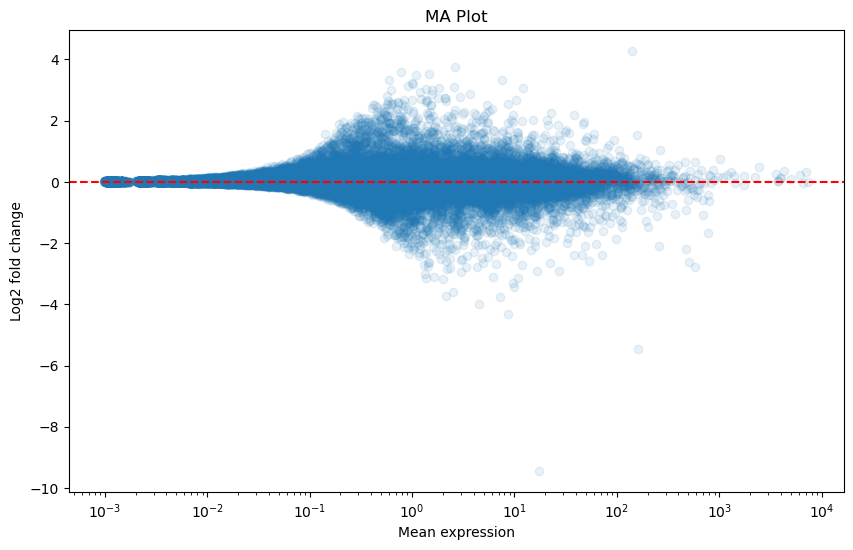

In [54]:

# Step 5: Visualize the results

# MA plot
plt.figure(figsize=(10, 6))
plt.scatter(results['baseMean'], results['log2FoldChange'], alpha=0.1)
plt.xscale('log')
plt.xlabel('Mean expression')
plt.ylabel('Log2 fold change')
plt.title('MA Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


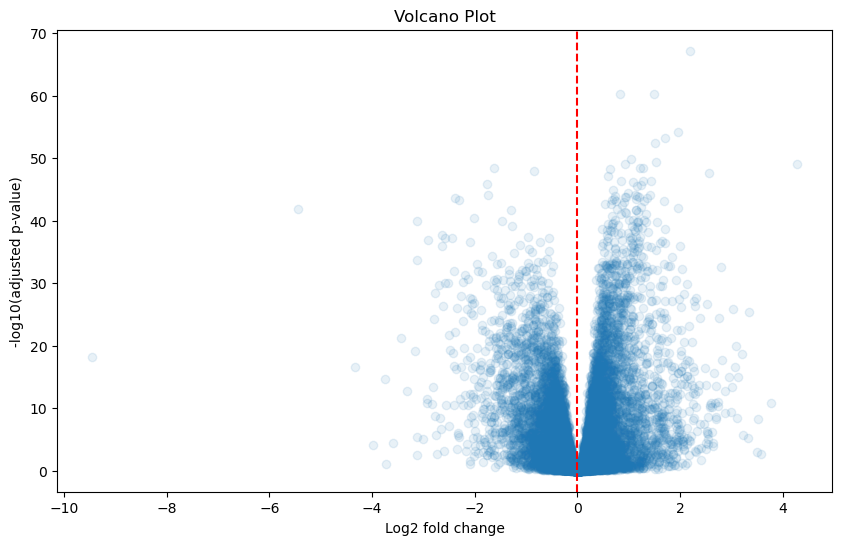

In [55]:

# Volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(results['log2FoldChange'], -np.log10(results['padj']), alpha=0.1)
plt.xlabel('Log2 fold change')
plt.ylabel('-log10(adjusted p-value)')
plt.title('Volcano Plot')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()


### Running decouplR on Top genes from Deseq

In [56]:
msigdb = dc.get_resource('MSigDB')
msigdb.drop_duplicates(inplace=True)

In [57]:
bottom_2_percent

index   baseMean  log2FoldChange  \
0       ENSG00000163975.12|MELTF|protein_coding   4.223192        2.197306   
1       ENSG00000115163.15|CENPA|protein_coding   4.405742        1.489792   
2      ENSG00000107937.19|GTPBP4|protein_coding  13.539092        0.820738   
3        ENSG00000136943.11|CTSV|protein_coding   2.170985        1.952020   
4       ENSG00000140545.15|MFGE8|protein_coding  31.920965        1.701760   
...                                         ...        ...             ...   
1208   ENSG00000152990.14|ADGRA3|protein_coding   4.064661        0.589959   
1209    ENSG00000133422.14|MORC2|protein_coding   6.271262        0.388311   
1210    ENSG00000185522.9|LMNTD2|protein_coding   1.187401       -1.446261   
1211  ENSG00000187045.19|TMPRSS6|protein_coding   2.285373       -1.874496   
1212    ENSG00000117625.14|RCOR3|protein_coding   8.095653       -0.512669   

         lfcSE       stat        pvalue          padj  
0     0.122265  17.971713  3.245360e-72  6.764303e-68  
1     0.087457  17.034557  4.551744e-65  4.743600e-61  
2     0.048266  17.004525  7.601871e-65  5.281526e-61  
3     0.120999  16.132468  1.508699e-58  7.861454e-55  
4     0.106421  15.990769  1.481895e-57  6.177426e-54  
...        ...        ...           ...           ...  
1208  0.066492   8.872677  7.140817e-19  1.231067e-17  
1209  0.043779   8.869824  7.326180e-19  1.261980e-17  
1210  0.163087  -8.868061  7.443043e-19  1.281052e-17  
1211  0.211414  -8.866466  7.550380e-19  1.298454e-17  
1212  0.057834  -8.864437  7.689148e-19  1.321228e-17  

[1213 rows x 7 columns]

In [58]:
deseq_genes = bottom_2_percent['index'].str.split('|').str[1]
gene_list = deseq_genes.to_list()

In [59]:
with open("/Users/johnsmith/Desktop/Senior Design Stuff/gencode.v47.annotation.gff3") as f:
    gff = list(f)

gff = [x for x in gff if not x.startswith('#')]

gff = [x for x in gff if 'gene_id=' in x and 'gene_name=' in x]

gff = list(map(lambda x: (x.split('gene_id=')[1].split(';')[0], x.split('gene_name=')[1].split(';')[0]), gff))

gff = dict(gff)

In [60]:
#mapped_genes = [gff[k] for k in deseq_genes]

In [61]:
ORA_df = dc.get_ora_df(
    df = gene_list,
    net = msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
)

Running ora on df with 1213 targets for 33552 sources with 20000 background features.


In [62]:
ORA_df['-log 10 p-value'] = np.log10(ORA_df['p-value'])*-1
test_pval_filt = ORA_df[ORA_df['p-value'] < 0.05]

test_pval_filt = test_pval_filt.sort_values(by=['-log 10 p-value'])
test_pval_filt.tail(10)

Term  Set size  Overlap ratio  \
14532   HE_LIM_SUN_FETAL_LUNG_C4_CYCLING_NK_CELL       668       0.296407   
22289                                  MODULE_54       262       0.488550   
19631          MEBARKI_HCC_PROGENITOR_FZD8CRD_UP       541       0.334566   
24800                SMID_BREAST_CANCER_BASAL_UP       655       0.303817   
14546        HE_LIM_SUN_FETAL_LUNG_C5_PRO_B_CELL       459       0.366013   
14545  HE_LIM_SUN_FETAL_LUNG_C5_LARGE_PRE_B_CELL      1341       0.215511   
1494         DUTERTRE_ESTRADIOL_RESPONSE_24HR_UP       322       0.450311   
2259   GOBERT_OLIGODENDROCYTE_DIFFERENTIATION_UP       572       0.340909   
1700                       FISCHER_DREAM_TARGETS       945       0.264550   
1665      FARMER_BREAST_CANCER_BASAL_VS_LULMINAL       326       0.475460   

             p-value   FDR p-value  Odds ratio  Combined score  \
14532   1.010445e-84  2.698898e-81    5.652846     1093.298707   
22289   3.952380e-85  1.172979e-81    8.901396     1729.945562   
19631   5.790568e-87  1.933326e-83    6.317130     1254.384036   
24800   2.532798e-87  9.664433e-84    5.803609     1157.213884   
14546   1.436915e-87  6.396666e-84    6.854065     1370.555416   
14545   1.931304e-88  1.031702e-84    4.355630      879.703506   
1494    2.767351e-90  1.847898e-86    8.309038     1713.446319   
2259    1.239594e-95  1.103652e-91    6.514026     1423.515383   
1700    3.929110e-96  5.247326e-92    5.239801     1151.078294   
1665   4.246080e-101  1.134128e-96    8.852380     2045.918679   

                                                Features  -log 10 p-value  
14532  ACTL6A;ALYREF;ANLN;APOBEC3B;ARHGAP11A;ASPM;ATA...        83.995487  
22289  AIF1L;ANLN;ANP32E;APOBEC3B;ARHGAP11A;ASPM;ATAD...        84.403141  
19631  ADGRB2;ANLN;ARHGAP11A;ASPM;ATAD2;AUNIP;AURKA;A...        86.237279  
24800  ACTG2;AGBL5;AMD1;ANP32E;APOBEC3B;ASPM;ATAD2;AT...        86.596399  
14546  AARS1;ADGRG1;ANLN;ARHGAP11A;ASPM;ATAD2;AURKA;A...        86.842569  
14545  AARS1;ACTL6A;AFG3L2;AGO2;ALYREF;ANLN;ANP32E;AP...        87.714149  
1494   ANLN;ARHGAP11A;ASPM;ATAD2;AURKA;AURKB;BIRC5;BL...        89.557936  
2259   AARS1;AKR1E2;ALAD;ANP32E;ARHGAP11A;ASPM;ATAD2;...        94.906721  
1700   AARS1;ACTL6A;AMD1;ANKRA2;ANLN;ANP32E;APOBEC3B;...        95.405706  
1665   ABAT;ACADSB;ACTL6A;ALDH6A1;AMD1;ANXA9;APBB2;AR...       100.372012

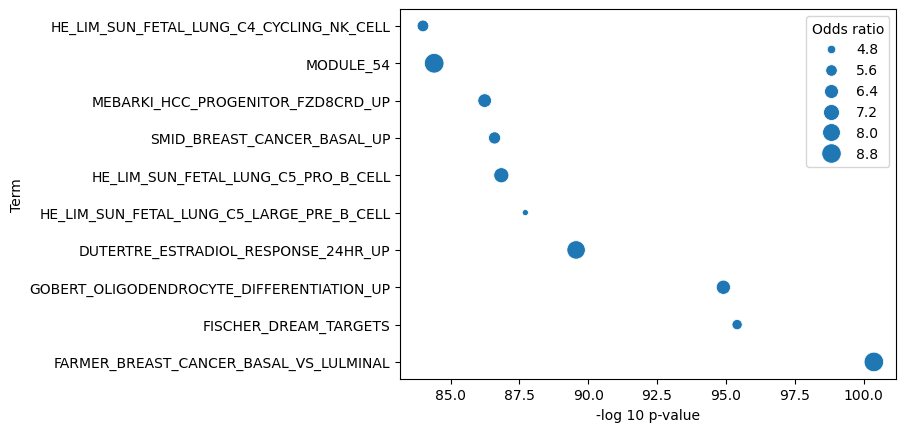

In [63]:
plot = sns.scatterplot(
    data=test_pval_filt.tail(10), x="-log 10 p-value", y="Term",  size="Odds ratio",
    sizes=(20, 200)
)